Aim : To use this dataset to categorise plaeyrs by country to be able to predict how good a country can be in the international matches \
Objective : Managers, Gamers will be able to know the best player for eac position on the game field or on game console

In [ ]:
!pip install unidecode


In [3]:
#import needed dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from scipy.stats import f_oneway, ttest_ind 
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error,r2_score
import warnings
from joblib import dump, load
from uuid import uuid
import os

In [4]:
warnings.filterwarnings('ignore')

In [5]:
# read csv file with pandas
data = pd.read_csv('fifa.csv', low_memory=False)

In [6]:
# call first 5 rows
data.head()

Name  Age Nationality  Overall Acceleration Aggression  \
0  Cristiano Ronaldo   32    Portugal       94       89         63       
1           L. Messi   30   Argentina       93       92         48       
2             Neymar   25      Brazil       92       94         56       
3          L. Suárez   30     Uruguay       92       88         78       
4           M. Neuer   31     Germany       92       58         29       

  Agility Balance Ball control Composure  ... Short passing Shot power  \
0  89      63           93        95      ...        83         94       
1  90      95           95        96      ...        88         85       
2  96      82           95        92      ...        81         80       
3  86      60           91        83      ...        83         87       
4  52      35           48        70      ...        55         25       

  Sliding tackle Sprint speed Stamina Standing tackle Strength  Vision  \
0         23           91      92              31       80      85       
1         26           87      73              28       59      90       
2         33           90      78              24       53      80       
3         38           77      89              45       80      84       
4         11           61      44              10       83      70       

  Volleys Preferred Positions  
0  88                  ST LW   
1  85                     RW   
2  83                     LW   
3  88                     ST   
4  11                     GK   

[5 rows x 39 columns]

In [7]:
# shape of dataset
data.shape

(17981, 39)

In [8]:
# check info about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17981 entries, 0 to 17980
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Name                 17981 non-null  object
 1   Age                  17981 non-null  int64 
 2   Nationality          17981 non-null  object
 3   Overall              17981 non-null  int64 
 4   Acceleration         17981 non-null  object
 5   Aggression           17981 non-null  object
 6   Agility              17981 non-null  object
 7   Balance              17981 non-null  object
 8   Ball control         17981 non-null  object
 9   Composure            17981 non-null  object
 10  Crossing             17981 non-null  object
 11  Curve                17981 non-null  object
 12  Dribbling            17981 non-null  object
 13  Finishing            17981 non-null  object
 14  Free kick accuracy   17981 non-null  object
 15  GK diving            17981 non-null  object
 16  GK h

some of the columns are of dtype objects instead of dtype integers

In [9]:
# check for missing value
data.isnull().sum().sum()

0

In [10]:
# change all column names to lower case for typing ease
data.columns = data.columns.str.lower()

In [11]:
# check the data types and total data type counts 
data.dtypes.value_counts()

object    37
int64      2
Name: count, dtype: int64

In [12]:
# change some columns dtype to int dtype
cols_num = (data.dtypes == 'O').index
cols_num = cols_num.drop(['name','preferred positions','nationality', 'overall','age']).tolist()

In [13]:
data['agility'].apply(lambda x: pd.eval(x))

0        89
1        90
2        96
3        86
4        52
         ..
17976    38
17977    35
17978    60
17979    58
17980    49
Name: agility, Length: 17981, dtype: int64

In [14]:
# total all un-summed values in all umerica columns
for col in cols_num:
    data[col] = data[col].apply(lambda x : eval(x))

In [15]:
# remove all extra spaces in the object type columns
data[['name','preferred positions','nationality']] = data[['name','preferred positions','nationality']].applymap(str.strip)

In [16]:
# transform all latin, german, norwagian, etc. letters to english letters
data.name = data.name.apply(unidecode)

In [17]:
# main positions
positions = 'GK CB LB RB CM RM LM RW LW ST'.split(' ')

In [18]:
# get all playing postions of the player
data['num of position'] = data['preferred positions'].apply(lambda x: len(x.split()))

# set the first postion as the most preferres position 
data['main position'] = data['preferred positions'].apply(lambda x: x if x in positions and x.split()[0].strip() else x if x in positions else x.split()[0].strip())

In [19]:
data.describe().T

count        mean          std   min   25%   50%   75%  \
age                 17981.0   25.144541     4.614272  16.0  21.0  25.0  28.0   
overall             17981.0   66.247984     6.987965  46.0  62.0  66.0  71.0   
acceleration        17981.0  103.362327   984.877556  11.0  56.0  67.0  75.0   
aggression          17981.0   77.572938   767.663944  11.0  43.0  59.0  69.0   
agility             17981.0   98.081475   909.695941  14.0  55.0  65.0  74.0   
balance             17981.0   86.581225   751.287441  11.0  56.0  66.0  74.0   
ball control        17981.0  121.133530  1232.914608   8.0  53.0  63.0  69.0   
composure           17981.0  103.637506  1026.429722   5.0  51.0  60.0  67.0   
crossing            17981.0   86.470107   910.701596   5.0  38.0  54.0  64.0   
curve               17981.0   62.597631   622.736138   6.0  34.0  49.0  62.0   
dribbling           17981.0  106.877315  1107.960799   2.0  48.0  61.0  68.0   
finishing           17981.0   93.195762  1068.114481   2.0  29.0  48.0  62.0   
free kick accuracy  17981.0   62.127190   648.841108   4.0  31.0  42.0  57.0   
gk diving           17981.0   31.947222   619.488414   1.0   8.0  11.0  14.0   
gk handling         17981.0   29.705856   567.410938   1.0   8.0  11.0  14.0   
gk kicking          17981.0   26.396307   477.595916   1.0   8.0  11.0  14.0   
gk positioning      17981.0   29.067071   536.803095   1.0   8.0  11.0  14.0   
gk reflexes         17981.0   32.988877   659.013090   1.0   8.0  11.0  14.0   
heading accuracy    17981.0   86.823925   900.682576   4.0  45.0  56.0  65.0   
interceptions       17981.0   90.894110  1132.294135   4.0  26.0  52.0  64.0   
jumping             17981.0  104.464101  1010.252964  13.0  58.0  66.0  73.0   
long passing        17981.0   91.423058   936.968529   7.0  42.0  56.0  64.0   
long shots          17981.0   73.787053   803.366140   3.0  32.0  51.0  63.0   
marking             17981.0  112.412435  1383.406057  -5.0  22.0  48.0  63.0   
penalties           17981.0   62.455759   530.214058   5.0  39.0  50.0  61.0   
positioning         17981.0   82.530616   926.854117   2.0  38.0  55.0  64.0   
reactions           17981.0  121.434125  1159.206157  28.0  56.0  62.0  68.0   
short passing       17981.0  115.011957  1154.424639  10.0  53.0  62.0  68.0   
shot power          17981.0   83.008954   809.972047   3.0  46.0  59.0  69.0   
sliding tackle      17981.0   89.504866  1072.335033   4.0  24.0  52.0  64.0   
sprint speed        17981.0  118.856182  1183.467534  11.0  57.0  67.0  75.0   
stamina             17981.0  122.947000  1259.237485  12.0  56.0  66.0  74.0   
standing tackle     17981.0  109.187253  1284.050227   4.0  26.0  54.0  66.0   
strength            17981.0  115.865247  1146.349903  12.0  58.0  66.0  74.0   
vision              17981.0   91.086425   943.814409  10.0  43.0  55.0  64.0   
volleys             17981.0   54.635838   523.265525   4.0  30.0  44.0  57.0   
num of position     17981.0    1.607975     0.758768   1.0   1.0   1.0   2.0   

                        max  
age                    47.0  
overall                94.0  
acceleration        33270.0  
aggression          43130.0  
agility             30164.0  
balance             31472.0  
ball control        43145.0  
composure           27150.0  
crossing            27150.0  
curve               43131.0  
dribbling           28491.0  
finishing           43126.0  
free kick accuracy  28185.0  
gk diving           29618.0  
gk handling         28522.0  
gk kicking          26665.0  
gk positioning      25965.0  
gk reflexes         31444.0  
heading accuracy    31048.0  
interceptions       43425.0  
jumping             29252.0  
long passing        29952.0  
long shots          43123.0  
marking             43305.0  
penalties           25689.0  
positioning         43376.0  
reactions           27760.0  
short passing       28856.0  
shot power          29677.0  
sliding tackle      43372.0  
sprint speed        32905.0  
stamina             4

There are many outliers in most column of which the maximum score is supposed to be 100

In [20]:
# replace all outliers in the dataset with the median of players postion's category  
data_cleaned = data.copy()
for col in cols_num:
    data_cleaned[col] = data.groupby('main position')[col].transform(lambda x: x.median() if (x > 100).any() else x).astype('int')

In [21]:
all_positions = data_cleaned['preferred positions'].str.get_dummies(' ').columns.tolist()
all_positions

['CAM',
 'CB',
 'CDM',
 'CF',
 'CM',
 'GK',
 'LB',
 'LM',
 'LW',
 'LWB',
 'RB',
 'RM',
 'RW',
 'RWB',
 'ST']

In [22]:
# seperate pereferred postions by forward, defence, midfield
forward = ['ST', 'LW', 'RW', 'CF']
midfield = 'CDM CAM LM RM CM'.split()
defence = 'CB RWB LWB LB RB'.split()

In [23]:
data_cleaned['FMD'] = data_cleaned['main position'].apply(lambda x: 'fwd' if x in forward else 'def' if x in defence else 'mid' if x in midfield else 'gk')

In [24]:
data_cleaned['FMD'].value_counts()

FMD
mid    7174
def    5440
fwd    3338
gk     2029
Name: count, dtype: int64

<AxesSubplot:xlabel='FMD', ylabel='overall'>

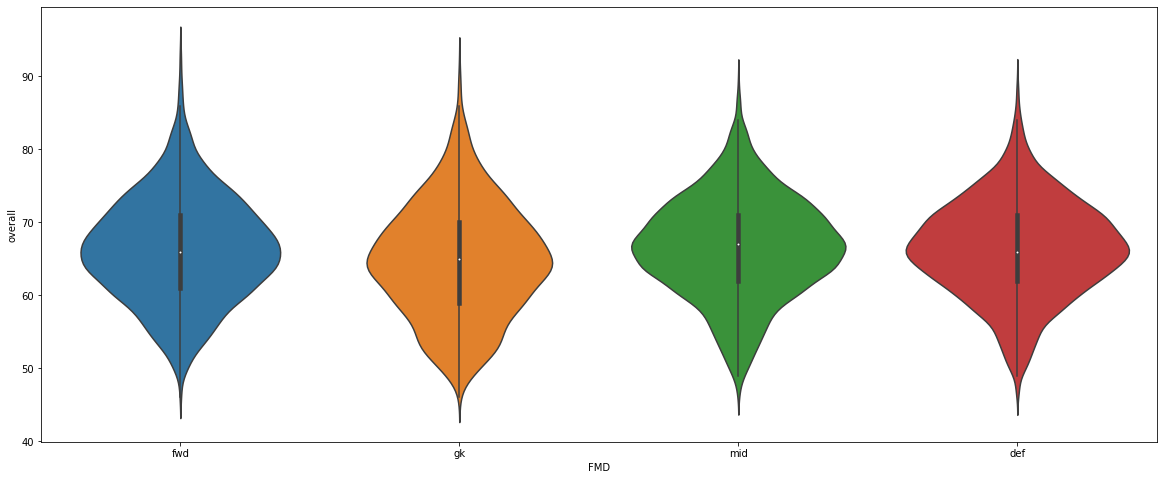

In [25]:
plt.figure(figsize=(20,8))
sns.violinplot(data = data_cleaned, x = 'FMD', y= 'overall')

In [26]:
def get_postion_best(position):
    '''
    rank given position in the world according to their overall ranking
    
    '''
    pos_data = data_cleaned.loc[data_cleaned['FMD'] == position].sort_values('overall',ascending = False) # 
    pos_data = pos_data.loc[:,['name','nationality','overall','main position']].reset_index(drop = True)
    pos_data.index = pos_data.index + 1 
    return pos_data

<AxesSubplot:xlabel='overall', ylabel='Count'>

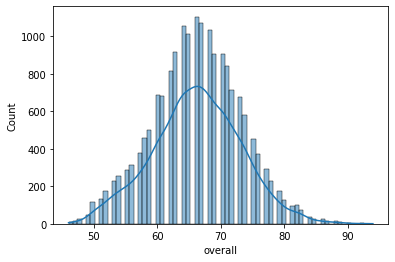

In [27]:
sns.histplot(data_cleaned['overall'],kde= True) # distribution of overall ranking of the players

In [28]:
# rank goal kepeper in the world according to their overall ranking
gk_data = get_postion_best('gk')
gk_data.head()

name nationality  overall main position
1     M. Neuer     Germany       92            GK
2       De Gea       Spain       90            GK
3  T. Courtois     Belgium       89            GK
4    G. Buffon       Italy       89            GK
5     J. Oblak    Slovenia       88            GK

In [29]:
# rank defenders in the world according to their overall ranking
def_data = get_postion_best('def')
def_data.head()

name nationality  overall main position
1  Sergio Ramos       Spain       90            CB
2  G. Chiellini       Italy       89            CB
3    L. Bonucci       Italy       88            CB
4    J. Boateng     Germany       88            CB
5      D. Godin     Uruguay       88            CB

In [30]:
# rank midfielders in the world according to their overall ranking
mid_data = get_postion_best('mid')
mid_data.head()

name nationality  overall main position
1      T. Kroos     Germany       90           CDM
2    A. Sanchez       Chile       89            RM
3     L. Modric     Croatia       89           CDM
4  K. De Bruyne     Belgium       89            RM
5        Thiago       Spain       88           CDM

In [31]:
# rank forward in the world according to their overall ranking
fwd_data = get_postion_best('fwd')
fwd_data.head()

name nationality  overall main position
1  Cristiano Ronaldo    Portugal       94            ST
2           L. Messi   Argentina       93            RW
3             Neymar      Brazil       92            LW
4          L. Suarez     Uruguay       92            ST
5     R. Lewandowski      Poland       91            ST

In [32]:
data['age'].describe()

count    17981.000000
mean        25.144541
std          4.614272
min         16.000000
25%         21.000000
50%         25.000000
75%         28.000000
max         47.000000
Name: age, dtype: float64

In [33]:
# classify players' ability based on age
labels =  'inxeperienced, prime, expeienced, retirement'.split(',')
age_mode = pd.cut(data_cleaned['age'],bins=[-float('inf'), 20,29,37, float('inf')], labels= labels)

<AxesSubplot:xlabel='age', ylabel='overall'>

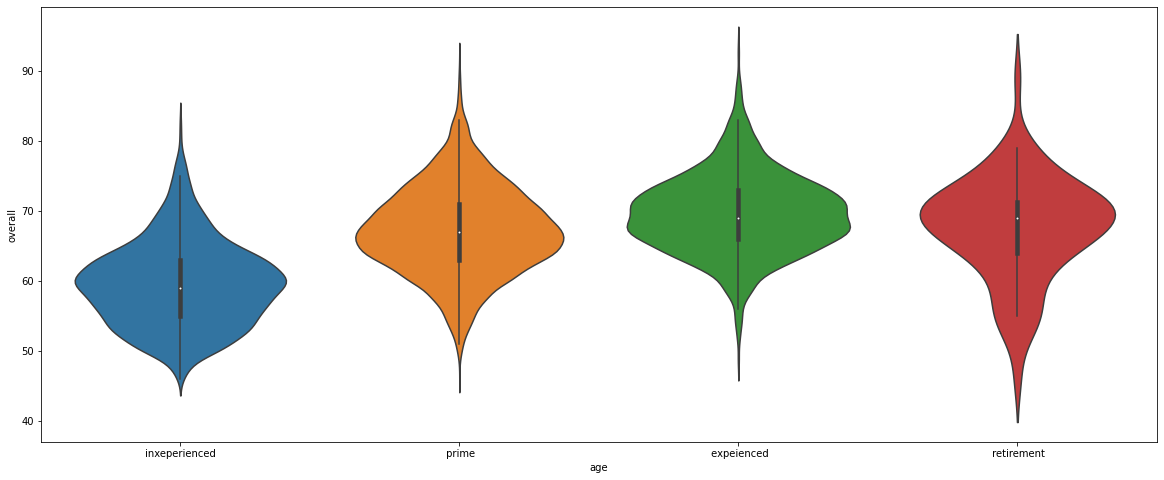

In [34]:
plt.figure(figsize=(20,8))
sns.violinplot(data_cleaned, x= age_mode, y = 'overall')

In [35]:
#best players for each feature and their score
best_player_feature = pd.concat([data_cleaned.set_index(['name'])[cols_num].idxmax(),data_cleaned[cols_num].max(0)],axis = 1).reset_index()
best_player_feature.columns = ['feature','name','score']
best_player_feature

feature          name  score
0         acceleration         Lucas     95
1           aggression  S. Dubarbier     90
2              agility        Neymar     96
3              balance       Bernard     96
4         ball control      L. Messi     95
5            composure        Neymar     92
6             crossing     K. Walker     65
7                curve       M. Reus     90
8            dribbling    A. Masuaku     80
9            finishing        Neymar     89
10  free kick accuracy      L. Messi     90
11           gk diving      M. Neuer     65
12         gk handling      M. Neuer     63
13          gk kicking      M. Neuer     61
14      gk positioning      M. Neuer     64
15         gk reflexes      M. Neuer     66
16    heading accuracy    M. Antonio     88
17       interceptions      J. Gomez     85
18             jumping      D. Perez     93
19        long passing  Borja Valero     86
20          long shots       G. Bale     90
21             marking       D. Rose     82
22           penalties    D. Perotti     90
23         positioning  A. Griezmann     91
24           reactions      L. Messi     95
25       short passing       M. Ozil     89
26          shot power       G. Bale     91
27      sliding tackle       D. Rose     85
28        sprint speed       J. Damm     95
29             stamina     A. Schopf     95
30     standing tackle       D. Rose     84
31            strength    D. Braaten     89
32              vision  K. De Bruyne     90
33             volleys  J. Rodriguez     91

In [36]:
# best player for each player position with their correspponding overall score and nationality
data_cleaned.groupby(['main position'])[['name','nationality','main position','overall']].head(2).sort_values(by = ['main position','overall'], ascending = [False, False]).reset_index(drop= True)

name nationality main position  overall
0       Cristiano Ronaldo    Portugal            ST       94
1               L. Suarez     Uruguay            ST       92
2               K. Walker     England           RWB       83
3   A. Oxlade-Chamberlain     England           RWB       80
4                L. Messi   Argentina            RW       93
5                 G. Bale       Wales            RW       89
6            K. De Bruyne     Belgium            RM       89
7              A. Sanchez       Chile            RM       89
8                Carvajal       Spain            RB       84
9              Dani Alves      Brazil            RB       84
10                D. Rose     England           LWB       82
11              B. Davies       Wales           LWB       78
12                 Neymar      Brazil            LW       92
13              E. Hazard     Belgium            LW       90
14             C. Eriksen     Denmark            LM       87
15            David Silva       Spain            LM       87
16                Marcelo      Brazil            LB       87
17             Jordi Alba       Spain            LB       85
18               M. Neuer     Germany            GK       92
19                 De Gea       Spain            GK       90
20               N. Kante      France            CM       87
21               A. Vidal       Chile            CM       87
22              S. Kagawa       Japan            CF       83
23                  Jonas      Brazil            CF       83
24               T. Kroos     Germany           CDM       90
25              L. Modric     Croatia           CDM       89
26           Sergio Ramos       Spain            CB       90
27           G. Chiellini       Italy            CB       89
28               Coutinho      Brazil           CAM       86
29          R. Nainggolan     Belgium           CAM       86

In [37]:
# low ranked player for each player position with their correspponding overall score and nationality
data_cleaned.groupby('main position')[['overall','name','nationality']].last()

overall            name          nationality
main position                                              
CAM                 47        L. Kiely  Republic of Ireland
CB                  46       J. Keeble              England
CDM                 49     C. Gnerlich              Germany
CF                  51  D. Evangelista                Italy
CM                  46    J. Lundstram              England
GK                  46   B. Richardson              England
LB                  48       E. Hughes     Northern Ireland
LM                  48     T. Robinson              England
LW                  51        E. Hodge              England
LWB                 51       S. Yawson              England
RB                  47         K. Egan              England
RM                  48       C. Nugent  Republic of Ireland
RW                  49    O. Dzonlagic          Switzerland
RWB                 51     E. Damgaard              Denmark
ST                  46       L. Sackey                Ghana

In [38]:
# average of each country's player overall score sorted by size(number of players) and mean of overall score
country_avg_score = data_cleaned.groupby('nationality')['overall'].agg(['size','sum','mean']).sort_values( by = ['size','sum'], ascending = [False, False]).reset_index()
country_avg_score.head()

nationality  size     sum       mean
0     England  1630  102804  63.069939
1     Germany  1140   75127  65.900877
2       Spain  1019   71268  69.939156
3      France   978   65806  67.286299
4   Argentina   965   65394  67.765803

In [39]:
import plotly.express as px

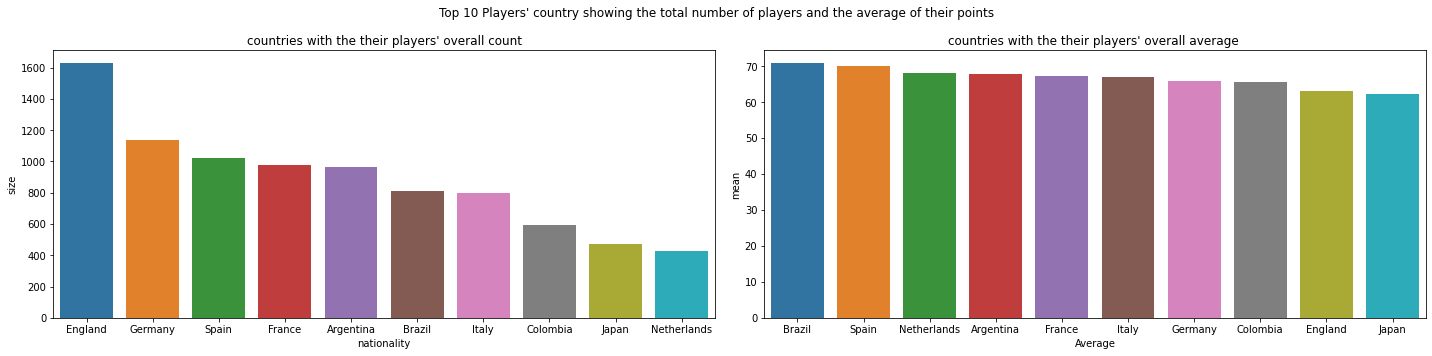

In [40]:
fig, axes = plt.subplots(1,2, figsize = (20,5))
axes = axes.flatten()
sns.barplot(data = country_avg_score[:10], x = 'nationality', y = 'size', ax= axes[0])
sns.barplot(data = country_avg_score[:10].sort_values(by = 'mean', ascending = False),  y= 'mean', x= 'nationality', ax = axes[1])
axes[1].set_title('countries with the their players\' overall average ')
axes[0].set_title('countries with the their players\' overall count')
plt.xlabel('Average')
plt.suptitle('Top 10 Players\' country showing the total number of players and the average of their points' )
plt.tight_layout()
plt.show()

In [41]:
#positions having the highest number of players
main_position_count = data_cleaned['main position'].value_counts().to_frame().reset_index()

In [42]:
sorted_pos = 'ST CF LW RW CDM CAM LM RM CM CB RWB LWB LB RB'.split(' ')

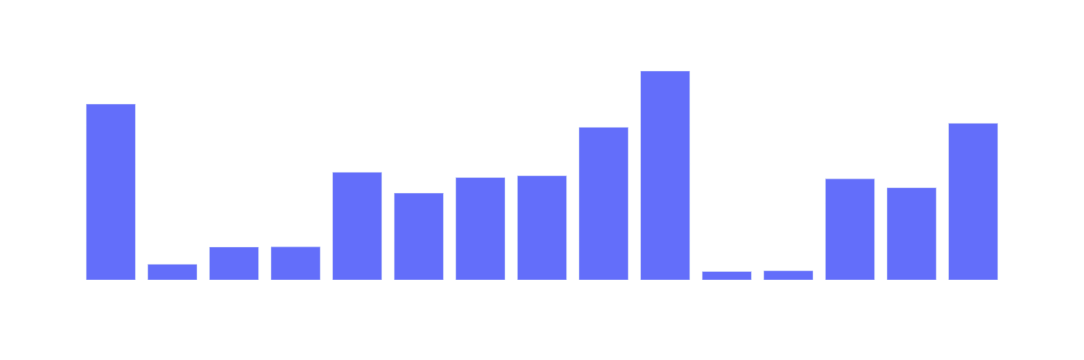

In [43]:
fig = px.bar(data_frame= main_position_count, x= 'main position', y = 'count', category_orders = {'main position':sorted_pos})
fig.update_layout(paper_bgcolor = 'rgba(0,0,0,0)',
                 plot_bgcolor = 'rgba(0,0,0,0)',
                 font_color = 'white')
fig.show()


As expected, CB is the most as most of the formation types require 2 CB

In [44]:
# oldest player(s) and youngest player(s)
data_cleaned[(data_cleaned['age'] == data_cleaned['age'].max()) | (data_cleaned['age'] == data_cleaned['age'].min())]

name  age  nationality  overall  acceleration  aggression  \
10556      K. Pierie   16  Netherlands       65            71          64   
11397       A. Gomes   16      England       64            66          63   
13733     E. Vignato   16        Italy       61            71          13   
15063   G. McEachran   16      England       59            66          63   
15119  L. Geertruida   16  Netherlands       59            71          66   
15571   Javi Vazquez   16        Spain       58            59          68   
15837      J. Romero   16    Argentina       58            70          53   
15968      E. Haland   16       Norway       58            70          53   
16116      M. Sprang   16      Germany       57            40          12   
17014    R. Strechie   16      Romania       54            66          63   
17025      L. Pintor   16       France       54            70          53   
17055     V. Barbero   16    Argentina       54            76          54   
17667        J. Hove   16       Norway       51            66          63   
17977  B. Richardson   47      England       46            40          44   

       agility  balance  ball control  composure  ...  sprint speed  stamina  \
10556       67       68            62         60  ...            72       72   
11397       67       69            66         62  ...            66       71   
13733       72       73            68         63  ...            70       59   
15063       67       69            66         62  ...            66       71   
15119       66       66            61         31  ...            71       71   
15571       54       56            54         60  ...            61       65   
15837       67       65            65         61  ...            71       65   
15968       67       65            65         61  ...            71       65   
16116       38       43            20         18  ...            41       31   
17014       67       69            66         62  ...            66       71   
17025       67       65            65         61  ...            71       65   
17055       75       73            67         61  ...            76       69   
17667       67       69            66         62  ...            66       71   
17977       38       43            20         44  ...            41       31   

       standing tackle  strength  vision  volleys  preferred positions  \
10556               66        67      51       37                LB CB   
11397               60        65      63       47         CM RW LW CAM   
13733               42        60      65       55                  CAM   
15063               60        65      63       47               CM CAM   
15119               66        68      49       36                RB CB   
15571               68        76      40       29                   CB   
15837               24        71      55       59                   ST   
15968               24        71      55       59                   ST   
16116               14        62      35       12                   GK   
17014               60        65      63       47                   CM   
17025               24        71      55       59                   ST   
17055               40        60      48       50                   RM   
17667               60        65      63       47                   CM   
17977               12        62      35       12                   GK   

       num of position  main position  FMD  
10556                2             LB  def  
11397                4             CM  mid  
13733                1            CAM  mid  
15063                2             CM  mid  
15119                2             RB  def  
15571                1             CB  def  
15837                1             ST  fwd  
15968                1             ST  fwd  
16116                1             GK   gk  
17014                1             CM  mid  
17025                1             ST  fwd  
17055   

In [45]:
corr_ = data_cleaned[cols_num].corr()

In [46]:
mask = np.tril(np.ones_like(corr_))

<AxesSubplot:>

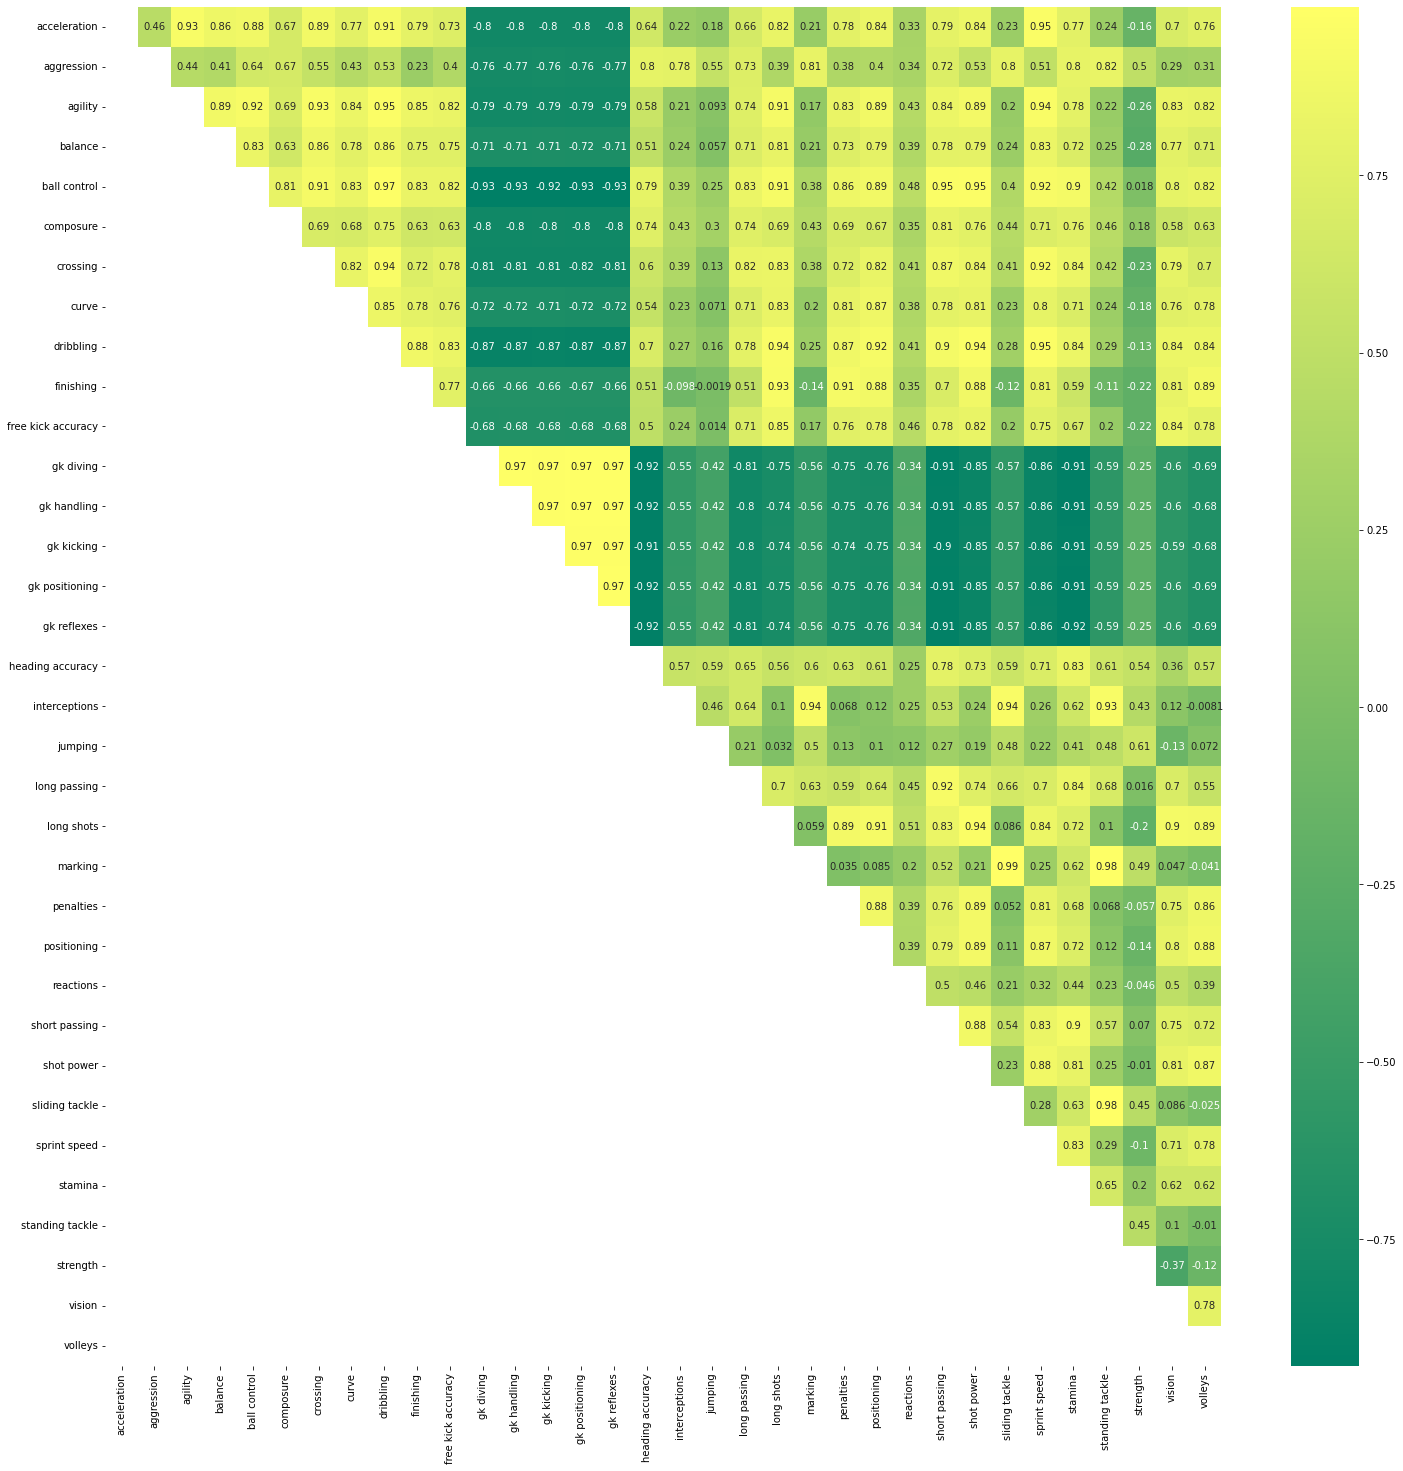

In [47]:
plt.figure(figsize=(25,25))
sns.heatmap(corr_, annot=True, mask = mask, cmap='summer')

### Overview of Nigerian Players

In [48]:
# All Nigerian players according to their overall ranking
nga_players = data_cleaned[(data_cleaned['nationality'] == 'Nigeria')].sort_values(by = 'overall', ascending = False).reset_index(drop = True)
nga_players.head()

name  age nationality  overall  acceleration  aggression  agility  \
0  V. Enyeama   34     Nigeria       80            40          39       38   
1    V. Moses   26     Nigeria       79            75          54       75   
2    O. Ndidi   20     Nigeria       77            66          63       67   
3     A. Musa   24     Nigeria       76            75          54       75   
4  L. Balogun   29     Nigeria       75            71          66       66   

   balance  ball control  composure  ...  sprint speed  stamina  \
0       43            20         24  ...            41       31   
1       73            67         61  ...            75       68   
2       69            66         62  ...            66       71   
3       73            67         61  ...            75       68   
4       52            61         72  ...            71       71   

   standing tackle  strength  vision  volleys  preferred positions  \
0               12        62      35       11                   GK   
1               40        60      61       53            LM RM RWB   
2               60        65      63       47               CM CDM   
3               40        60      61       53                LM ST   
4               66        68      49       36                RB CB   

   num of position  main position  FMD  
0                1             GK   gk  
1                3             LM  mid  
2                2             CM  mid  
3                2             LM  mid  
4                2             RB  def  

[5 rows x 42 columns]

Text(0.5, 0, "Number of Players' position")

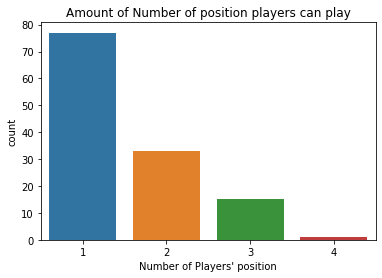

In [49]:
plt.Figure((15,8))
sns.countplot(data = nga_players, x= 'num of position')
plt.title('Amount of Number of position players can play')
plt.xlabel('Number of Players\' position')

Text(0.5, 1.0, 'Age distribution of Nigerian players')

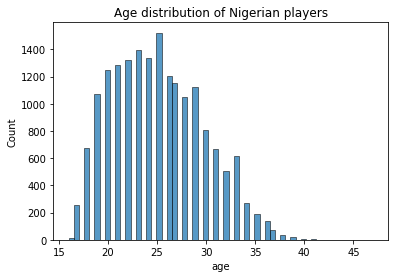

In [50]:
plt.Figure((15,8))
sns.histplot(data['age'])
plt.title('Age distribution of Nigerian players')

The graph above shows that most of the Nigerian players are very young

Text(0.5, 1.0, 'Age distribution of Nigerian players')

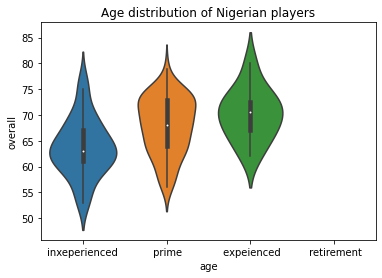

In [51]:
# classify players' ability based on age
plt.Figure((15,8))
labels =  'inxeperienced, prime, expeienced, retirement'.split(',')
age_mode = pd.cut(nga_players['age'],bins=[-float('inf'), 20,29,37, float('inf')], labels= labels)
sns.violinplot(x= age_mode, y =nga_players['overall'])
plt.title('Age distribution of Nigerian players')

Most of the Nigerian players are spanning from inexperienced to Experienced players

<AxesSubplot:xlabel='FMD', ylabel='Count'>

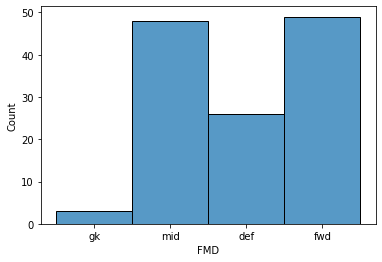

In [52]:
plt.Figure((15,8))
sns.histplot(nga_players['FMD'])

The above figure shows that Nigeria has more offensive players when compared to the defence  

Text(0.5, 1.0, 'Distribution of overall score of Nigerian players')

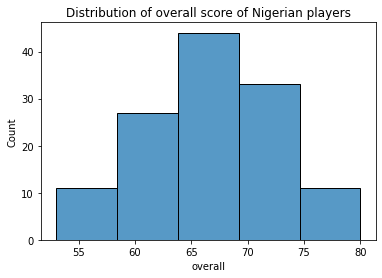

In [53]:
plt.Figure((15,8))
sns.histplot(data = nga_players, x = 'overall', bins = 5)
plt.title('Distribution of overall score of Nigerian players')

The average overall score of Nigerian players on the fifa ranking ranges from 64 to 69 

In [54]:
#Median overall score
nga_players['overall'].median()

67.0

In [55]:
#Average overall score
nga_avg_overall_score = nga_players['overall'].mean()
nga_avg_overall_score

66.76190476190476

The mean is 66.76 while the median is 67. This shows the data is evenly distributed

In [56]:
world_avg_overall_score = data_cleaned['overall'].mean()
world_avg_overall_score

66.24798398309326

In [57]:
#best players for each feature and their score
players_feat_NGA = pd.concat([nga_players.set_index(['name'])[cols_num].idxmax(),nga_players[cols_num].max(0)],axis = 1).reset_index()
players_feat_NGA.columns = ['feature','name','score']
players_feat_NGA

feature          name  score
0         acceleration      K. Fatai     86
1           aggression  E. Echiejile     80
2              agility     E. Dennis     81
3              balance  I. Uzochukwu     86
4         ball control       C. Ezeh     78
5            composure    L. Balogun     72
6             crossing  E. Echiejile     64
7                curve      O. Onazi     75
8            dribbling     E. Dennis     70
9            finishing     E. Dennis     71
10  free kick accuracy      S. Aluko     76
11           gk diving    V. Enyeama     65
12         gk handling    V. Enyeama     63
13          gk kicking    V. Enyeama     61
14      gk positioning    V. Enyeama     64
15         gk reflexes    V. Enyeama     66
16    heading accuracy     K. Omeruo     66
17       interceptions  E. Echiejile     69
18             jumping      K. Fatai     78
19        long passing      O. Ndidi     65
20          long shots  E. Echiejile     69
21             marking  E. Echiejile     72
22           penalties      K. Fatai     73
23         positioning      O. Onazi     68
24           reactions  E. Echiejile     68
25       short passing       C. Ezeh     69
26          shot power  E. Echiejile     80
27      sliding tackle  E. Echiejile     72
28        sprint speed     E. Dennis     77
29             stamina      R. Lawal     89
30     standing tackle  E. Echiejile     74
31            strength  E. Echiejile     77
32              vision       S. Kalu     69
33             volleys    E. Emenike     73

In [58]:
compare_feat = pd.concat([players_feat_NGA.drop('name', axis = 1), best_player_feature['score'], np.abs(players_feat_NGA['score'] - best_player_feature['score'])], axis = 1)
compare_feat.columns = ['feature	score	world_score differnce'.split()]
compare_feat

feature score world_score differnce
0         acceleration    86          95         9
1           aggression    80          90        10
2              agility    81          96        15
3              balance    86          96        10
4         ball control    78          95        17
5            composure    72          92        20
6             crossing    64          65         1
7                curve    75          90        15
8            dribbling    70          80        10
9            finishing    71          89        18
10  free kick accuracy    76          90        14
11           gk diving    65          65         0
12         gk handling    63          63         0
13          gk kicking    61          61         0
14      gk positioning    64          64         0
15         gk reflexes    66          66         0
16    heading accuracy    66          88        22
17       interceptions    69          85        16
18             jumping    78          93        15
19        long passing    65          86        21
20          long shots    69          90        21
21             marking    72          82        10
22           penalties    73          90        17
23         positioning    68          91        23
24           reactions    68          95        27
25       short passing    69          89        20
26          shot power    80          91        11
27      sliding tackle    72          85        13
28        sprint speed    77          95        18
29             stamina    89          95         6
30     standing tackle    74          84        10
31            strength    77          89        12
32              vision    69          90        21
33             volleys    73          91        18

Recommendations:
Nigeria needs to have
- more defensive players and Goalkeepers
- Goal keepers need to improve on :
    - Long passes 
    - Long shots
- Midfielders need to improve on:
    - Crossing
    - Vision
    - Marking
- Forward need to improve on:
    - Crossing
    - Vollleying
    - Aggression
- Defence need to improve on:
    - Having more experienced defenders

General :
- Players from Nigeria need to improve as the average of their overall score is less than 0.6


#####  Getting dummies of nationality and playing positions

In [59]:
data_scores = data.drop(['main position', 'preferred positions','nationality','name'], axis = 1)
data_scores.head()

age  overall  acceleration  aggression  agility  balance  ball control  \
0   32       94            89          63       89       63            93   
1   30       93            92          48       90       95            95   
2   25       92            94          56       96       82            95   
3   30       92            88          78       86       60            91   
4   31       92            58          29       52       35            48   

   composure  crossing  curve  ...  short passing  shot power  sliding tackle  \
0         95        85     81  ...             83          94              23   
1         96        77     89  ...             88          85              26   
2         92        75     81  ...             81          80              33   
3         83        77     86  ...             83          87              38   
4         70        15     14  ...             55          25              11   

   sprint speed  stamina  standing tackle  strength  vision  volleys  \
0            91       92               31        80      85       88   
1            87       73               28        59      90       85   
2            90       78               24        53      80       83   
3            77       89               45        80      84       88   
4            61       44               10        83      70       11   

   num of position  
0                2  
1                1  
2                1  
3                1  
4                1  

[5 rows x 37 columns]

In [60]:
country_data = data['nationality'].str.get_dummies()
country_data.head()

Afghanistan  Albania  Algeria  Angola  Antigua & Barbuda  Argentina  \
0            0        0        0       0                  0          0   
1            0        0        0       0                  0          1   
2            0        0        0       0                  0          0   
3            0        0        0       0                  0          0   
4            0        0        0       0                  0          0   

   Armenia  Australia  Austria  Azerbaijan  ...  Uganda  Ukraine  \
0        0          0        0           0  ...       0        0   
1        0          0        0           0  ...       0        0   
2        0          0        0           0  ...       0        0   
3        0          0        0           0  ...       0        0   
4        0          0        0           0  ...       0        0   

   United States  Uruguay  Uzbekistan  Venezuela  Vietnam  Wales  Zambia  \
0              0        0           0          0        0      0       0   
1              0        0           0          0        0      0       0   
2              0        0           0          0        0      0       0   
3              0        1           0          0        0      0       0   
4              0        0           0          0        0      0       0   

   Zimbabwe  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 165 columns]

In [61]:
# get dummies for all playing postions in dataframe
data_pos = data['preferred positions'].str.get_dummies(sep = ' ')
data_pos.head()

CAM  CB  CDM  CF  CM  GK  LB  LM  LW  LWB  RB  RM  RW  RWB  ST
0    0   0    0   0   0   0   0   0   1    0   0   0   0    0   1
1    0   0    0   0   0   0   0   0   0    0   0   0   1    0   0
2    0   0    0   0   0   0   0   0   1    0   0   0   0    0   0
3    0   0    0   0   0   0   0   0   0    0   0   0   0    0   1
4    0   0    0   0   0   1   0   0   0    0   0   0   0    0   0

## Data Modeling

In [62]:
# concatenate all numeric dtype columns for model
data_4_model = pd.concat([data_scores,country_data,data_pos],axis = 1)

data_4_model.head()

age  overall  acceleration  aggression  agility  balance  ball control  \
0   32       94            89          63       89       63            93   
1   30       93            92          48       90       95            95   
2   25       92            94          56       96       82            95   
3   30       92            88          78       86       60            91   
4   31       92            58          29       52       35            48   

   composure  crossing  curve  ...  GK  LB  LM  LW  LWB  RB  RM  RW  RWB  ST  
0         95        85     81  ...   0   0   0   1    0   0   0   0    0   1  
1         96        77     89  ...   0   0   0   0    0   0   0   1    0   0  
2         92        75     81  ...   0   0   0   1    0   0   0   0    0   0  
3         83        77     86  ...   0   0   0   0    0   0   0   0    0   1  
4         70        15     14  ...   1   0   0   0    0   0   0   0    0   0  

[5 rows x 217 columns]

In [63]:
X = data_4_model.drop(['overall'], axis = 1)
y =  data_4_model['overall']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=.3, shuffle= True)

In [64]:
rfr = RandomForestRegressor(n_estimators=100, random_state=12, n_jobs=-1)

In [65]:
rfr.fit(train_X, train_y)

RandomForestRegressor(n_jobs=-1, random_state=12)

In [66]:
y_pred = rfr.predict(test_X)

In [86]:
models= {}
def model_metrics(model, pred):
    print('Model Training Score: {}'.format(model.score(train_X,train_y)))
    print('R squared score: {}'.format(r2_score(test_y,pred)))
    print('Mean squared error: {}'.format(mean_squared_error(test_y,pred)))
    
    models[type(model).__name__] = r2_score(test_y,pred)
    if not os.path.isdir('fifa models'):
        !mkdir "fifa models"
    filename = input('Enter name to save model: ') or f'{type(model).__name__}'
    file = os.sep.join(['fifa models',filename])
    dump(model, file)

In [68]:
model_metrics(rfr,y_pred)

Model Training Score: 0.9939170311206987
R squared score: 0.9580914857908589
Mean squared error: 2.0167951621872104


Enter name to save model:  


In [69]:
#compare predicted output with test
pd.concat([pd.Series(test_y,name= 'true y').reset_index(drop =True),pd.Series(y_pred.round(), name="Predicted y")],axis = 1).astype(int).sample(10)

true y  Predicted y
3131      58           58
3866      76           76
1664      65           66
5047      82           82
2417      70           69
2331      62           62
89        73           75
5133      66           65
583       74           74
5334      70           70

<AxesSubplot:xlabel='overall', ylabel='Density'>

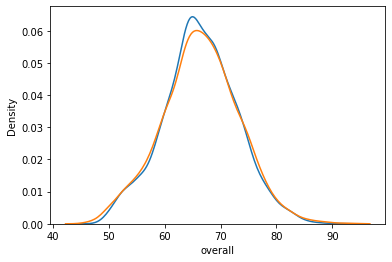

In [70]:
# plot of predicted overall score vs true overall score
sns.distplot(y_pred,hist = False)
sns.distplot(test_y,hist = False)

In [71]:
feature_importance = pd.DataFrame(zip(test_X.columns,rfr.feature_importances_)).rename(columns = {0:'feature',1:'importance'})
feature_importance = feature_importance.sort_values(by ='importance',ascending=False).reset_index(drop = True)

In [72]:
feature_importance.head()

feature  importance
0        reactions    0.648117
1     ball control    0.085708
2  standing tackle    0.042697
3          marking    0.027082
4        composure    0.024570

In [73]:
def feat_imp(feature_importance,model_name):
    fig,ax = plt.subplots(figsize=(20,8))
    x_upper_lim = plt.xlim()[1]
    x_lower_lim = plt.xlim()[0]
    feature_importance.iloc[0:20,:].plot.barh(x ='feature', y= 'importance', legend = False, ax = ax)
    
    for p in ax.patches: 
        percentage = '{:.1f}%'.format(100 * p.get_width() / sum(feature_importance['importance']))
        x = p.get_x() + p.get_width() + 0.009 
        y = p.get_y() + p.get_height() -.45
        ax.annotate(percentage, (x, y), fontsize=10)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Importances')
    ax.set_title('Top 20 feature importances of {}'.format(model_name))

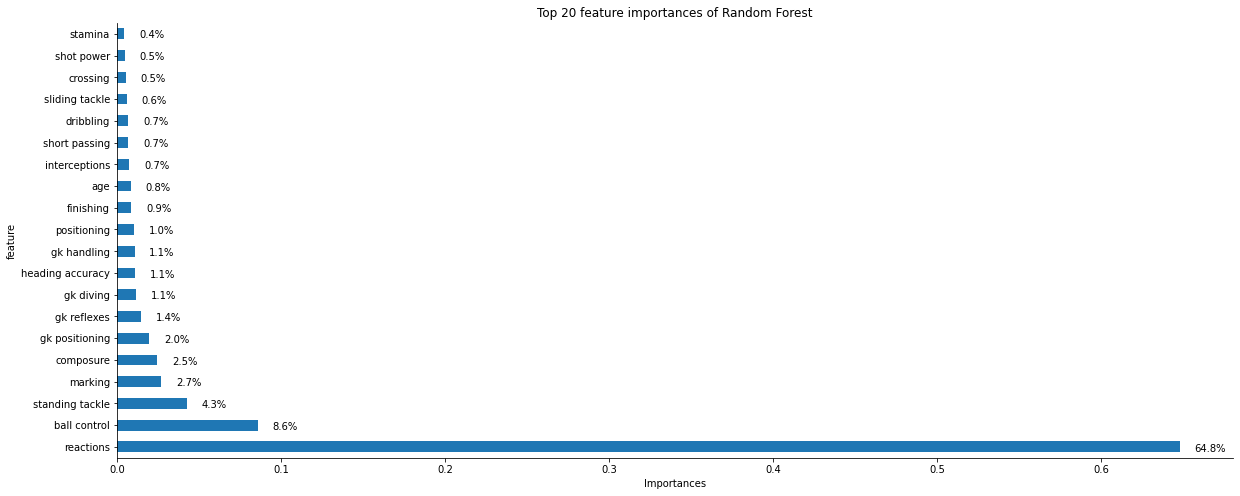

In [74]:
feat_imp(feature_importance, 'Random Forest')

The model predicts the following as the main factor that affects players overall ranking:
- Reaction
- Ball control
- Standing tackle
- composure 
- marking

### Decision Tree Model

In [75]:
# Define the parameter grid
param_grid = {
    'criterion': ['mse', 'mae'],  # Splitting criterion
    'splitter': ['best', 'random'],  # Strategy used to choose the split at each node
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Create a Decision Tree Regressor
dt_regressor = DecisionTreeRegressor()

# Create GridSearchCV object
grid_search = RandomizedSearchCV(dt_regressor, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, n_iter= 5)

grid_search.fit(train_X, train_y)


KeyboardInterrupt: 

In [ ]:
grid_search.best_score_,grid_search.best_params_

In [76]:
DecisionTreeRegressor(max_depth=12).fit(train_X, train_y).score(test_X,test_y) #vanilla model

0.8950162657922149

In [77]:
dtr = DecisionTreeRegressor(max_depth=12,criterion='mae', min_samples_leaf=2, min_samples_split=10, random_state=12)

In [78]:
dtr.fit(train_X, train_y)

DecisionTreeRegressor(criterion='mae', max_depth=12, min_samples_leaf=2,
                      min_samples_split=10, random_state=12)

In [79]:
dtr_pred = dtr.predict(test_X)

In [80]:
model_metrics(dtr,dtr_pred)

Model Training Score: 0.9522274722800795
R squared score: 0.899793038263221
Mean squared error: 4.8223354958294715


Enter name to save model:  


### XGBoost Model

In [81]:
xgb_reg = XGBRegressor(learning_rate=0.1, n_estimators=100, max_depth=12, random_state = 12)
# learning_rate: Controls how much the model learns from each iteration. A lower learning rate will make the model more conservative in its updates.
# n_estimators: The number of trees in the model. A higher number of trees will make the model more complex and accurate, but will also take longer to train.
# max_depth: The maximum depth of each tree in the model. A higher max_depth will make the model more complex and accurate, but will also take longer to train.


In [82]:
xgb_reg.fit(train_X, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=12, ...)

In [87]:
xgb_reg_pred = xgb_reg.predict(test_X)
model_metrics(xgb_reg,xgb_reg_pred)

Model Training Score: 0.9992912847216691
R squared score: 0.970895721680281
Mean squared error: 1.4006072231822562


Enter name to save model:  


In [90]:
features_importances = pd.DataFrame(zip(xgb_reg.feature_names_in_,xgb_reg.feature_importances_))
features_importances.columns = ['feature', 'importance']
features_importances = features_importances.sort_values(by='importance', ascending=False).reset_index(drop= True)

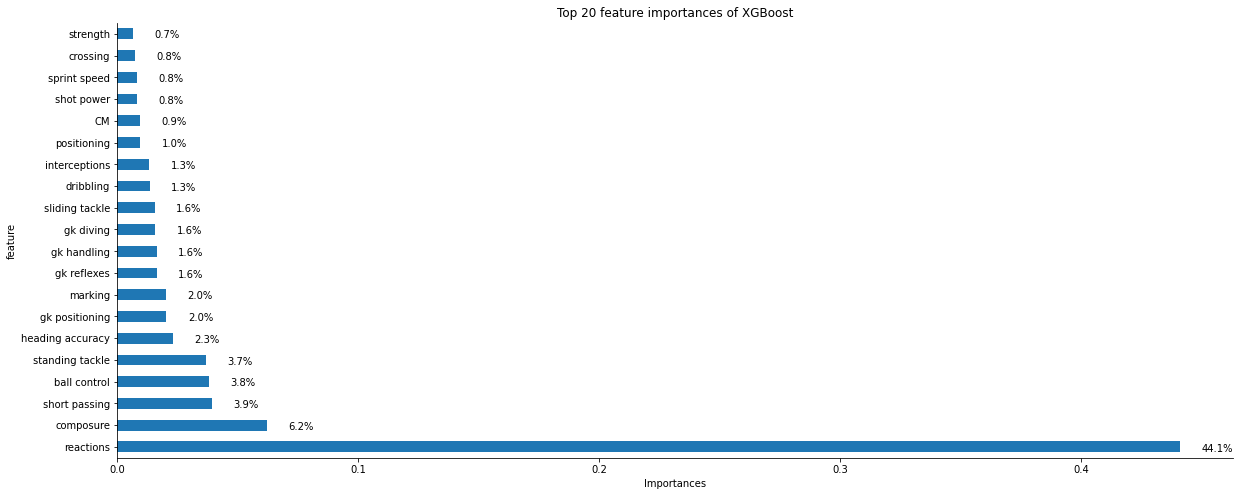

In [91]:
feat_imp(features_importances, 'XGBoost')

In [92]:
best_model = max(models)
best_model

'XGBRegressor'

### Hypothesis Testing

Player playing position has effect on the verall performance

H<i><sub>0</sub> : The playing position of a player does not affects the player overall performance</i>  <br>
H<i><sub>1</sub> : The playing position of a player does affects the player overall performance</i>  <br>

In [ ]:
data_cleaned['FMD'].unique()

In [ ]:
forward = data_cleaned.loc[data_cleaned['FMD'] == 'fwd', 'overall']
midfield = data_cleaned.loc[data_cleaned['FMD'] == 'mid', 'overall']
defence = data_cleaned.loc[data_cleaned['FMD'] == 'def', 'overall']
gk = data_cleaned.loc[data_cleaned['FMD'] == 'gk', 'overall']

In [ ]:
alpha_value = 0.05
statictic, p_value = f_oneway(forward,midfield, defence, gk) # using one way ANOVA test
p_value

H<i><sub>0</sub> : The number of positions of a player does not add to their overall performance</i>  <br>
H<i><sub>1</sub> : The number of positions of a player adds to their overall performance</i> 

In [ ]:
one_position = data_cleaned.loc[data_cleaned['num of position'] == 1, 'overall']
two_positions = data_cleaned.loc[data_cleaned['num of position'] == 2, 'overall']
three_positions = data_cleaned.loc[data_cleaned['num of position'] == 3, 'overall']
four_positions = data_cleaned.loc[data_cleaned['num of position'] >= 4, 'overall']

In [ ]:
alpha_value = 0.05
statictic, p_value = f_oneway(one_position,two_positions, three_positions, four_positions) # using one way ANOVA test
p_value

In [ ]:
if p_value < alpha_value:
    print(f'Null hypothesis rejected, The number of positions of a player does not contributes to player\'s overall performance')
else:
    print(f'Failed to reject null hypotheis, The number of positions of a player contributes to player\'s overall performance')

In [ ]:
# age of players play significant role in the overall ranking 
#Players above the average age have better overall scores

H0 : there is no relationship between the age of players and the overall ranking\
H1 : the age of players has an effect on the overall ranking of the players

In [ ]:
alpha_value = 0.05
static, p_value = pearsonr(data_cleaned['age'], data_cleaned['overall'])
p_value

In [ ]:
if p_value < alpha_value :
    print('Reject Null hypothesis, Age has no significance on the overall ranking of players')  
else:
    print('Failed to reject null hypothesis, Age has significance correlation on the overall ranking of players')

In [ ]:
pd.crosstab(data['overall'],data['num of position'], margins = True).reset_index()

In [98]:
%%cmd
git add fifa-player-ranking.ipynb
git commit -m "added more models"
git push origin main

Microsoft Windows [Version 6.1.7601]
Copyright (c) 2009 Microsoft Corporation.  All rights reserved.

C:\Users\AMOS OSHIYOYE\Documents\VSCODE_user_files\Fifa>git add fifa-player-ranking.ipynb

C:\Users\AMOS OSHIYOYE\Documents\VSCODE_user_files\Fifa>git commit -m "added more models"
On branch main
Untracked files:
  (use "git add <file>..." to include in what will be committed)
	.ipynb_checkpoints/
	README.md
	RandomForestRegressor
	fifa decision tree model
	fifa models/
	fifa xgboost model
	fifa-ranking/
	fifa.csv
	fifa_model.joblib
	test.csv
	train.csv

nothing added to commit but untracked files present (use "git add" to track)

C:\Users\AMOS OSHIYOYE\Documents\VSCODE_user_files\Fifa>git push origin main


fatal: 'origin' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.



C:\Users\AMOS OSHIYOYE\Documents\VSCODE_user_files\Fifa>